In [1]:
library(tscount)
library(ggplot2)
options(repr.matrix.max.cols=20, repr.matrix.max.rows=30)

In [4]:
patient = "JE"
path.data = '../data/'

In [5]:
data = read.csv(paste0(path.data, 'features_day_', patient, '_acausal4.csv'))

In [9]:
t = as.matrix(data['Time'])
data.Sz = as.matrix(data['Seizures'])
cov.week.hist = as.matrix(data[ , grepl('Weekly', names(data)), drop=FALSE])

In [10]:
threshold = 1  # for patients with low number of seizures
category.data.Sz = data.Sz
category.data.Sz[category.data.Sz<threshold] = 0
category.data.Sz[category.data.Sz>0] = 1
data.Sz = category.data.Sz
# We have re-defined the seizure timeseries as binary. 

In [11]:
eval.cut = 6
length.train = min(floor(0.60*length(data.Sz)), 48*8) - (eval.cut + 1)
t.cut = t[eval.cut:length(t)]
data.Sz.cut = data.Sz[eval.cut:length(data.Sz)]

In [12]:
train.t = t.cut[1:length.train]
train.Sz = data.Sz.cut[1:length.train]
test.t = t.cut[(length.train+1):length(data.Sz.cut)]
test.Sz = data.Sz.cut[(length.train+1):length(data.Sz.cut)]

In [13]:
cov.week.hist = rbind(cov.week.hist[1,,drop=FALSE], cov.week.hist[1:(nrow(cov.week.hist) - 1),,drop=FALSE])

In [14]:
cov.week.hist.cut = cov.week.hist[eval.cut:length(data.Sz),,drop=FALSE]
cov.week.hist.train = cov.week.hist.cut[1:length.train,,drop=FALSE]
cov.week.hist.test = cov.week.hist.cut[(length.train+1):length(data.Sz.cut),,drop=FALSE]

In [15]:
Sz.with.week.hist.fit = tsglm(train.Sz, xreg=cov.week.hist.train, link="log", distr="poisson")

In [17]:
preds.test = predict(Sz.with.week.hist.fit, 
                     n.ahead=length((length.train+1):length(data.Sz.cut)), 
                     newxreg=cov.week.hist.test, 
                     level=0)

In [19]:
df = data.frame(Time=test.t, Seizures=test.Sz, Forecasts.week.hist=preds.test$pred)

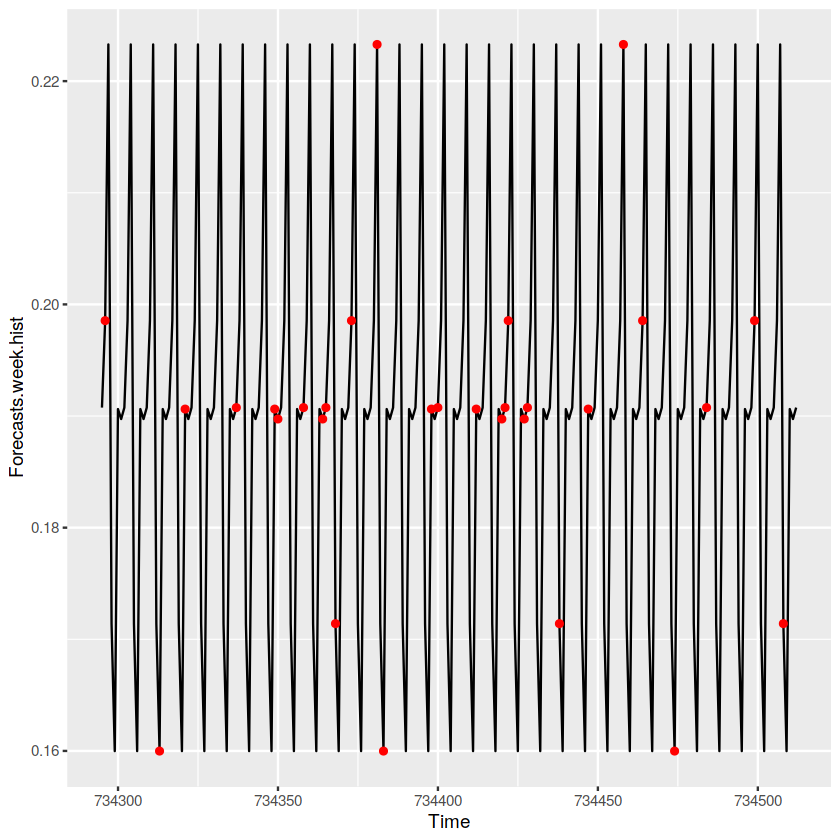

In [20]:
ggplot() + 
geom_line(data=df, mapping=aes(Time, Forecasts.week.hist)) +  
geom_point(data=df[df$Seizures %in% 1,], mapping=aes(x=Time, y=Forecasts.week.hist), color='red') 